# 说明
选择的数据集：
* SNAP(Stanford Large Network Dataset Collection)：采用wget http://snap.stanford.edu/data/act-mooc.tar.gz 下载MOOC用户操作数据集
* Microsoft 资讯推荐：采用wget https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip 下载MIND的小规模训练数据集

## MOOC用户操作数据集
是SNAP(Stanford Large Network Dataset Collection)数据集中的一种，主页在：http://snap.stanford.edu/data/act-mooc.html

### 数据获取与预处理
* 数据获取：采用wget http://snap.stanford.edu/data/act-mooc.tar.gz 下载MOOC用户操作数据集
包含三个文件：
1. mooc_actions.tsv：用户操作的按时间顺序排列
2. mooc_action_features.tsv：与每个操作相关的功能
3. mooc_action_labels.tsv：与每个操作关联的二进制标签，指示学生在操作后是否退学
* 数据预处理：操作如下
1. 处理数据中的缺失值（由代码结果看，本数据集中无缺失值）
2. 数据整合：将三个文件通过ACTION字段整合到一个文件中，并分为训练集和测试集，所有的数据按着ACTION排序
3. 转换为图数据结构：根据网页的描述，这个数据集是网络，应为图数据结构

In [3]:
import pandas as pd

# 加载数据
actions = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions.tsv', delimiter='\t')
features = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_action_features.tsv', delimiter='\t')
labels = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_action_labels.tsv', delimiter='\t')

# 数据清洗
# 检查是否存在缺失值
if actions.isnull().values.any():
    print("Cleaning actions data - dropping missing values.")
    actions = actions.dropna()

if features.isnull().values.any():
    print("Cleaning features data - dropping missing values.")
    features = features.dropna()

if labels.isnull().values.any():
    print("Cleaning labels data - dropping missing values.")
    labels = labels.dropna()

# 数据整合
actions_with_features = pd.merge(actions, features, on='ACTIONID')
actions_with_features_labels = pd.merge(actions_with_features, labels, on='ACTIONID')
# 按ACTIONID排序
actions_with_features_labels = actions_with_features_labels.sort_values(by='ACTIONID')

# 数据集划分
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(actions_with_features_labels, test_size=0.2, random_state=42)
# 按ACTIONID排序训练集和测试集
train_data = train_data.sort_values(by='ACTIONID')
test_data = test_data.sort_values(by='ACTIONID')

# 数据集存储
train_data.to_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_train_data.csv', index=False)
test_data.to_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_test_data.csv', index=False)

In [9]:
# 将数据集文件转换为图数据结构
import pandas as pd
import networkx as nx

def convert_to_graph(filename):
    # 读取数据集文件
    df = pd.read_csv(filename)

    # 创建空图
    G = nx.DiGraph()

    # 添加节点
    G.add_nodes_from(df['USERID'], type='user')
    G.add_nodes_from(df['TARGETID'], type='target')

    # 添加带有属性的边
    for _, row in df.iterrows():
        edge_attrs = {
            'timestamp': row['TIMESTAMP'],
            'feature0': row['FEATURE0'],
            'feature1': row['FEATURE1'],
            'feature2': row['FEATURE2'],
            'feature3': row['FEATURE3'],
            'label':row['LABEL']
        }
        G.add_edge(row['USERID'], row['TARGETID'], **edge_attrs)

    return G

# 处理训练集数据
train_graph = convert_to_graph('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_train_data.csv')
print("训练集图信息：")
print(train_graph)
#nx.write_gpickle(train_graph, '/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_train_graph.gpickle')

# 处理测试集数据
test_graph = convert_to_graph('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_test_data.csv')
print("验证集图信息：")
print(test_graph)
#nx.write_gpickle(test_graph, '/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_test_graph.gpickle')

训练集图信息：
DiGraph with 7047 nodes and 157420 edges
验证集图信息：
DiGraph with 6700 nodes and 63678 edges


### 频繁模式挖掘
1. 模式命名：用户-目标活动模式（识别用户在MOOC平台上的常见行为序列）
2. 由于数据集较大，本实验采用FP-Growth算法进行频繁模式挖掘，代码如下：

In [8]:
import pandas as pd
import pyfpgrowth

# 逐块读取数据
chunk_size = 10000  # 每次读取的行数
reader = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/act-mooc/mooc_actions_train_data.csv', chunksize=chunk_size)

# 初始化空列表来存储所有事务
transactions = []

# 逐块处理数据
for chunk in reader:
    # 提取USERID和TARGETID作为项集
    items = chunk[['USERID', 'TARGETID']]
    
    # 每个用户的操作序列作为一个事务
    for _, group in items.groupby('USERID'):
        transactions.append(list(group['TARGETID'].unique()))

# 使用pyfpgrowth库进行频繁模式挖掘
patterns = pyfpgrowth.find_frequent_patterns(transactions, len(transactions)*0.05)
rules = pyfpgrowth.generate_association_rules(patterns, 0.1)

# 对频繁项集按照支持度从高到低排序并输出
sorted_freq_itemsets = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
# 输出频繁项集
print("频繁项集：")
for itemset, support_count in sorted_freq_itemsets:
    print(f"{itemset}: {support_count}")

# 对关联规则按照置信度从高到低排序并输出
sorted_rules = sorted(rules.items(), key=lambda item: item[1][1], reverse=True)
# 输出关联规则
print("\n关联规则：")
for antecedent, (consequent, confidence) in sorted_rules:
    print(f"{antecedent} => {consequent}: {confidence}")


频繁项集：
(8,): 10208
(7,): 7519
(12,): 5831
(22,): 4827
(25,): 4482
(1, 3): 4446
(3, 13): 4105
(7, 14): 4088
(7, 9): 4028
(7, 8): 4027
(3, 4): 3970
(23,): 3833
(4, 5): 3593
(21,): 3546
(8, 9): 3498
(9, 14): 3285
(36,): 3208
(4, 15): 3145
(3, 5): 3079
(1, 4): 3045
(3, 8): 2947
(5, 16): 2939
(4, 8): 2930
(5, 6): 2915
(1, 13): 2915
(27,): 2910
(24,): 2905
(5, 8): 2890
(7, 9, 14): 2846
(6, 17): 2796
(3, 15): 2782
(37,): 2778
(3, 7): 2760
(22, 32): 2731
(7, 17): 2699
(10,): 2659
(3, 9): 2594
(5, 7): 2562
(1, 3, 13): 2557
(4, 7): 2549
(1, 7): 2531
(4, 13): 2507
(25, 26): 2494
(1, 2): 2486
(4, 6): 2481
(6, 7): 2481
(1, 3, 4): 2472
(3, 4, 5): 2463
(15, 16): 2439
(7, 8, 14): 2439
(25, 27): 2420
(6, 8): 2402
(7, 8, 9): 2396
(34,): 2370
(51,): 2288
(40,): 2245
(3, 13, 15): 2245
(31,): 2203
(21, 51): 2191
(42,): 2181
(3, 4, 13): 2181
(12, 22): 2179
(26, 28): 2137
(6, 18): 2132
(3, 4, 15): 2129
(8, 25): 2119
(7, 14, 17): 2113
(17, 19): 2111
(1, 8): 2103
(36, 37): 2063
(25, 28): 2063
(4, 5, 6): 2031
(2

### 可视化结果展示

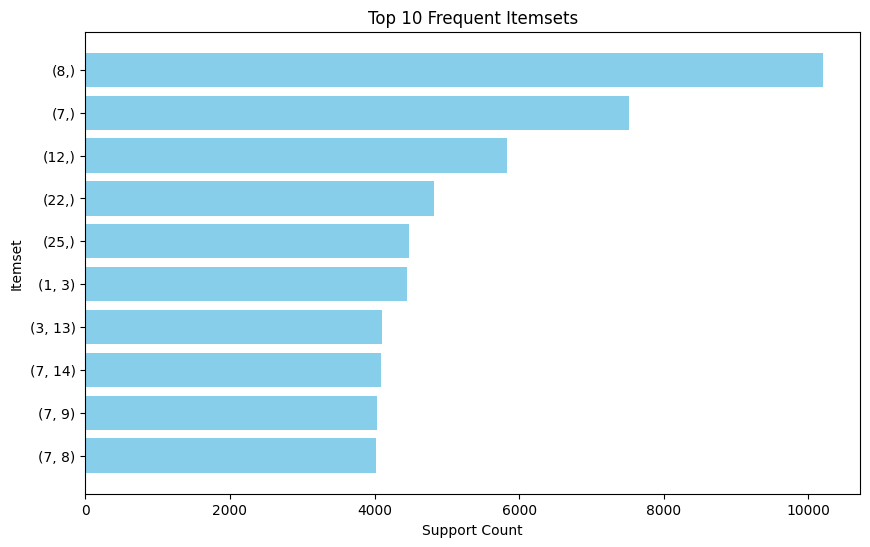

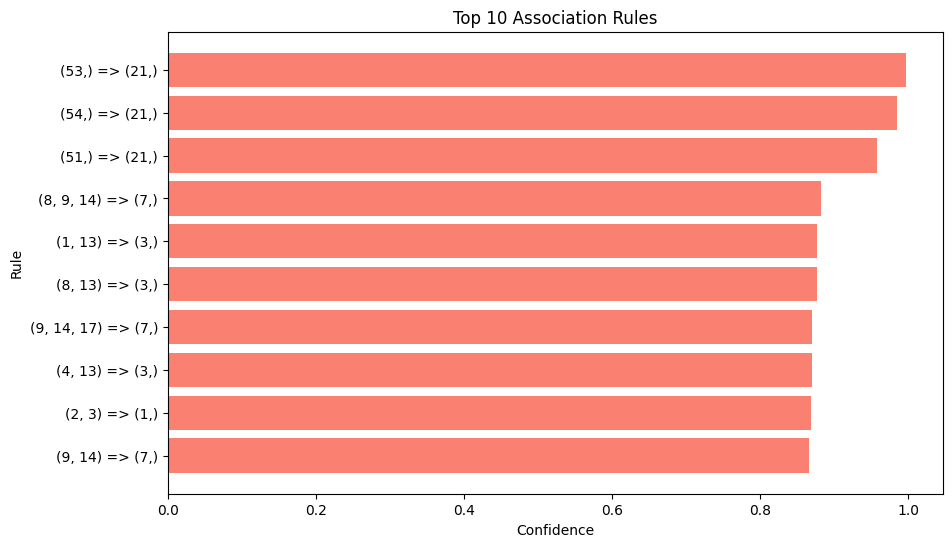

In [9]:
import matplotlib.pyplot as plt

# 频繁项集可视化
plt.figure(figsize=(10, 6))
plt.barh([str(itemset) for itemset, _ in sorted_freq_itemsets[:10]], [support_count for _, support_count in sorted_freq_itemsets[:10]], color='skyblue')
plt.xlabel('Support Count')
plt.ylabel('Itemset')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()  # 使得支持度高的项集在顶部显示
plt.show()

# 关联规则可视化
plt.figure(figsize=(10, 6))
plt.barh([f"{antecedent} => {consequent}" for antecedent, (consequent, confidence) in sorted_rules[:10]], [confidence for _, (consequent, confidence) in sorted_rules[:10]], color='salmon')
plt.xlabel('Confidence')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules')
plt.gca().invert_yaxis()  # 使得置信度高的规则在顶部显示
plt.show()


### 挖掘结果分析
1. 频繁项集分析：
    * 如 (8,)、(7,)、(12,) 等，这些表示特定的 TARGETID 出现得非常频繁。例如，(8,) 出现了 10208 次，这可能意味着与 TARGETID 8 相关的课程或资源非常受欢迎或广泛被用户操作
    * 如 (1, 3)、(3, 13)、(7, 14)、(7, 9) 等，这些表示某些 TARGETID 的组合经常一起出现。这可能表明用户在进行操作时，倾向于在操作了某个 TARGETID 之后紧接着操作另一个特定的 TARGETID
    * 频繁项集的支持度（即出现的次数）可以告诉我们哪些 TARGETID 或 TARGETID 的组合在用户操作中更为常见。这可以用于推荐系统，例如，推荐那些频繁一起被操作的课程或资源
2. 关联规则分析：
    * 关联规则中的置信度（confidence）表示在前件发生的情况下后件发生的概率。例如，(53,) => (21,): 0.9966795794133924 表示在操作 53 发生的情况下，紧接着发生操作 21 的概率非常高
    * 一些关联规则可能对于理解用户行为模式非常有用。例如，(1, 13) => (3,): 0.8771869639794168 可能表明用户在进行了操作 1 和 13 之后，有很大的可能性会进行操作 3
    * 通过分析关联规则，我们可以推断出用户的操作习惯。例如，如果 (8, 9, 14) => (7,) 是一个强规则，那么可能意味着用户在操作了 TARGETID 8、9 或 14 之后，通常会操作 TARGETID 7
    * 这些规则可以用于个性化推荐，例如，根据用户的前几个操作推荐他们可能感兴趣的下一个操作

## Microsoft 资讯推荐数据
Microsoft 资讯推荐数据集（Microsoft News Dataset，MIND）包含了新闻文章的信息和用户的行为日志，主页在：https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets#behaviorstsv 

### 数据获取与预处理
* 数据获取：采用 wget https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip 下载Microsoft 资讯推荐数据集
包含以下文件：
1. behaviors.tsv：用户的点击历史记录和映像日志
2. news.tsv：新闻文章的信息
* 数据预处理：操作如下
1. 处理数据中的缺失值
2. 数据整合：通过behaviors.tsv文件中的用户点击新闻历史与news.tsv文件中的新闻id，合并成一个新的由用户id、新闻浏览历史、和浏览新闻类型的新文件。以便后续对其进行频繁模式挖掘和关联模式挖掘

In [21]:
import pandas as pd

# 读取数据时手动指定列名
behaviors_columns = ['ID', 'userID', 'time', 'history', 'dianji']
behaviors = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/behaviors.tsv', delimiter='\t', names=behaviors_columns)

# 读取数据时手动指定列名
news_columns = ['newID', 'category', 'sub-category', 'title', 'abstract', 'code', 'title-entity', 'abstract-entity']
news = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/news.tsv', delimiter='\t', names=news_columns)

# 数据清洗
# 检查是否存在缺失值
if behaviors.isnull().values.any():
    print("Cleaning behaviors data - dropping missing values.")
    behaviors = behaviors.dropna()

if news.isnull().values.any():
    print("Cleaning news data - dropping missing values.")
    news = news.dropna()

# 数据预处理
# 转换时间格式为机器可读格式
behaviors['time'] = pd.to_datetime(behaviors['time'])

# 读取新闻数据
news_columns = ['newID', 'category']
news = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/news.tsv', delimiter='\t', usecols=[0, 1], names=news_columns)

# 只保留 userID 和 history
behaviors = behaviors[['userID', 'history']]
behaviors.to_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/user-history.csv')

# 展开 history 中的项目
expanded_behaviors = behaviors.assign(history=behaviors['history'].str.split(' ')).explode('history')

# 使用 newID 将新闻类别拼接到展开后的数据中
merged_data = pd.merge(expanded_behaviors, news, left_on='history', right_on='newID', how='left')

# 只保留一列名为"history/newID"
merged_data.rename(columns={'history': 'history/newID'}, inplace=True)
merged_data.drop(columns=['newID'], inplace=True)

# 保存新的文件
merged_data.to_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/merged_data.csv', index=False)

# 输出结果检查
print(merged_data.head())

Cleaning behaviors data - dropping missing values.
Cleaning news data - dropping missing values.
   userID history/newID category
0  U13740        N55189       tv
1  U13740        N42782   sports
2  U13740        N34694       tv
3  U13740        N45794     news
4  U13740        N18445   sports


### 频繁模式挖掘
1. 模式命名：
    * 用户新闻类别模式：对新闻类别进行频繁项集挖掘，同时进行关联模式挖掘，找出用户对哪些类别的新闻感兴趣
2. 由于数据集较大，本实验采用FP-Growth算法进行频繁模式挖掘，代码如下：

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# 读取数据集
merged_data_chunks = pd.read_csv('/home/yimeng/my_test/course/DataMining/dataset/Microsoft-news/merged_data.csv', usecols=['userID', 'category'], chunksize=10000)

# 初始化一个空的列表来存储所有事务
transactions = []

# 逐块处理数据
for i, chunk in enumerate(merged_data_chunks):
    # 将每个用户的 category 组合成事务
    transactions.extend(chunk.groupby('userID')['category'].apply(list))
    #print(f"处理第 {i+1} 个数据块，共 {len(transactions)} 条事务")

# 对类别型数据进行编码转换
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 mlxtend 库进行频繁模式挖掘
min_support = 0.5  # 假设我们想要1%的支持度
frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

# 对频繁项集按照支持度从高到低排序
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)
# 输出频繁项集
print("频繁项集：")
print(frequent_itemsets_sorted)

# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
# 对关联规则按照置信度从高到低排序
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# 输出关联规则
print("\n关联规则：")
print(rules_sorted)


频繁项集：
     support             itemsets
0   0.898481               (news)
1   0.701221          (lifestyle)
2   0.683225             (sports)
3   0.651338                 (tv)
5   0.650947    (news, lifestyle)
6   0.635674       (news, sports)
4   0.621431            (finance)
8   0.607019           (tv, news)
10  0.590697      (finance, news)
9   0.519019      (tv, lifestyle)
7   0.505069  (sports, lifestyle)

关联规则：
    antecedents  consequents  antecedent support  consequent support  \
10    (finance)       (news)            0.621431            0.898481   
6          (tv)       (news)            0.651338            0.898481   
3      (sports)       (news)            0.683225            0.898481   
1   (lifestyle)       (news)            0.701221            0.898481   
8          (tv)  (lifestyle)            0.651338            0.701221   
9   (lifestyle)         (tv)            0.701221            0.651338   
4      (sports)  (lifestyle)            0.683225            0.701221   
0  

### 可视化结果展示

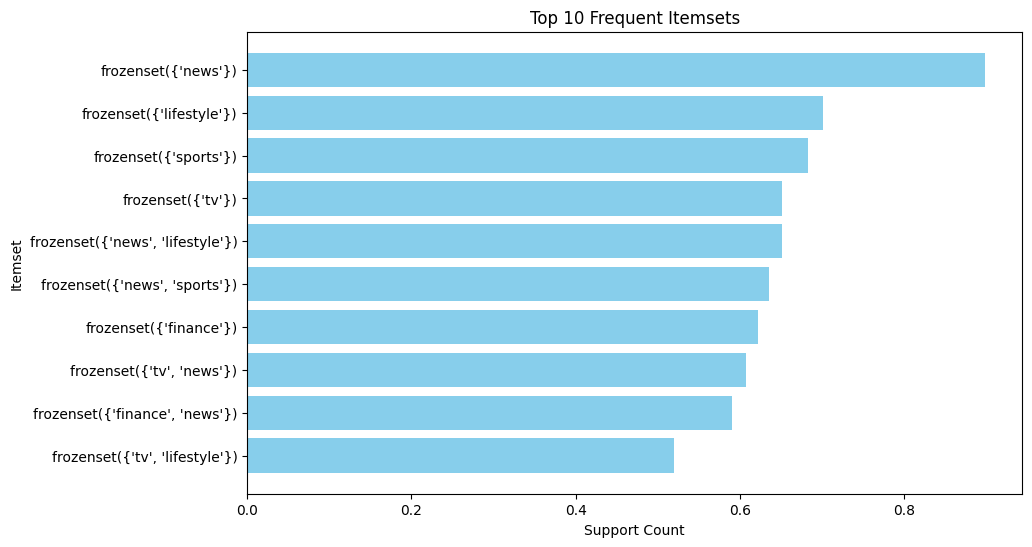

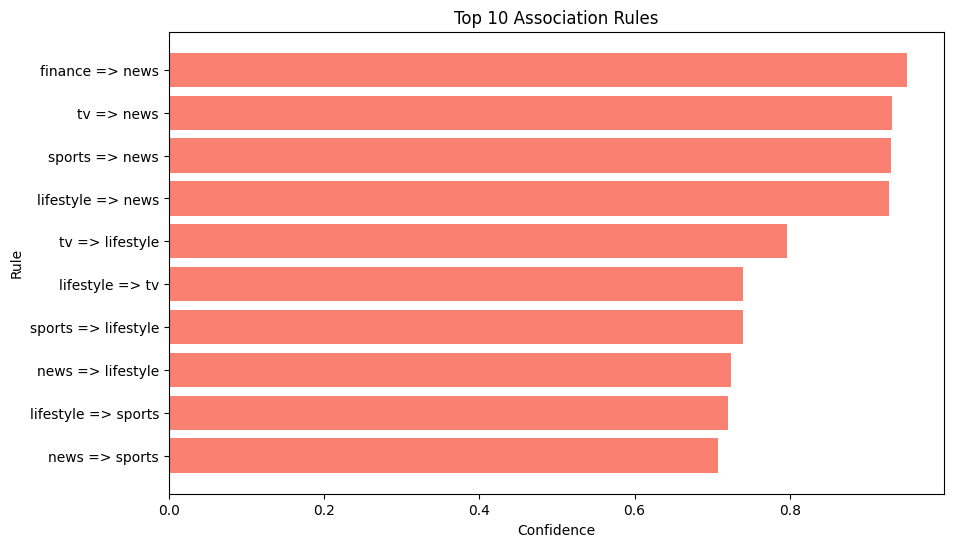

In [8]:
import matplotlib.pyplot as plt

# 频繁项集可视化
plt.figure(figsize=(10, 6))
plt.barh([str(itemset) for itemset in frequent_itemsets_sorted['itemsets'][:10]], frequent_itemsets_sorted['support'][:10], color='skyblue')
plt.xlabel('Support Count')
plt.ylabel('Itemset')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()  # 使得支持度高的项集在顶部显示
plt.show()

# 关联规则可视化
plt.figure(figsize=(10, 6))
plt.barh([f"{', '.join(antecedent)} => {', '.join(consequent)}" for antecedent, consequent in rules_sorted[['antecedents', 'consequents']][:10].apply(lambda row: (row['antecedents'], row['consequents']), axis=1)], rules_sorted['confidence'][:10], color='salmon')
plt.xlabel('Confidence')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules')
plt.gca().invert_yaxis()  # 使得置信度高的规则在顶部显示
plt.show()


### 挖掘结果分析
1. 频繁项集分析：
    * 最频繁的项目是 "news"，支持度为 0.898。这表明大多数情况下，用户浏览的新闻主要集中在 "news" 类别下
    * 其他频繁项集包括 "lifestyle"、"sports"、"tv" 和 "finance"。这些项目的支持度相对较高，说明它们也是用户关注的热门类别
    * 组合项集如 "(news, lifestyle)"、"(news, sports)" 等显示了一些类别之间的关联性，例如新闻类别与生活方式、体育类别的组合
2. 关联规则分析：
    * 规则 "(finance) => (news)" 具有最高的置信度，为 0.951。这表明如果用户浏览了 "finance" 类别的新闻，则他们浏览 "news" 类别的概率较高
    * 类似地，规则 "(tv) => (news)"、"(sports) => (news)" 和 "(lifestyle) => (news)" 也具有很高的置信度，分别为 0.932、0.930 和 0.928。这些规则显示了不同类别之间的关联性，用户在浏览某一类别的新闻后，浏览 "news" 类别的概率相对较高
3. 综上所述，通过频繁项集和关联规则的分析，我们可以了解用户对不同类别的新闻的偏好以及这些类别之间的关联性。这些分析可以帮助新闻平台优化内容推荐和分类系统，提高用户体验和内容吸引力